In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
#%matplotlib notebook
%matplotlib notebook
mpl.style.use('ggplot') # optional: for ggplot-like style

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
housedata =  pd.read_csv('data/lianjia100_clean.csv')

<IPython.core.display.Javascript object>


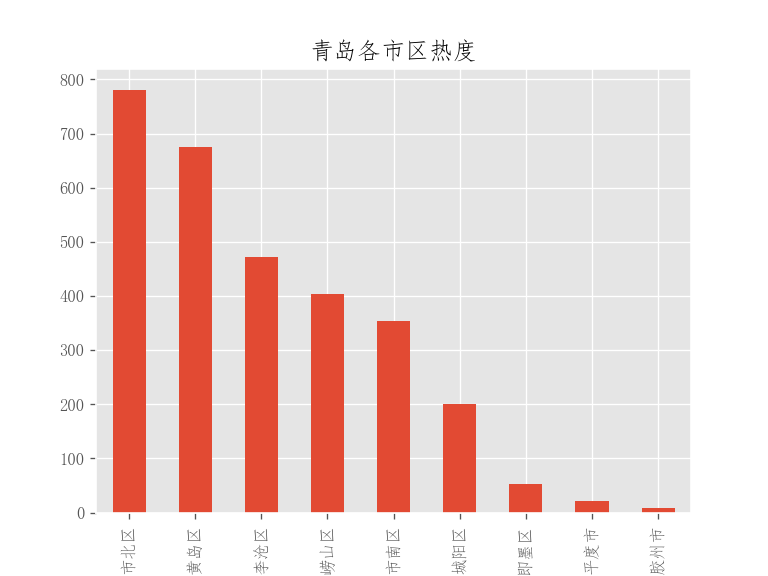

In [11]:
housedata['市区'].value_counts().plot(kind='bar')
plt.title('青岛各市区热度')

plt.savefig('fig/districts-trend.png')
plt.show()

<IPython.core.display.Javascript object>


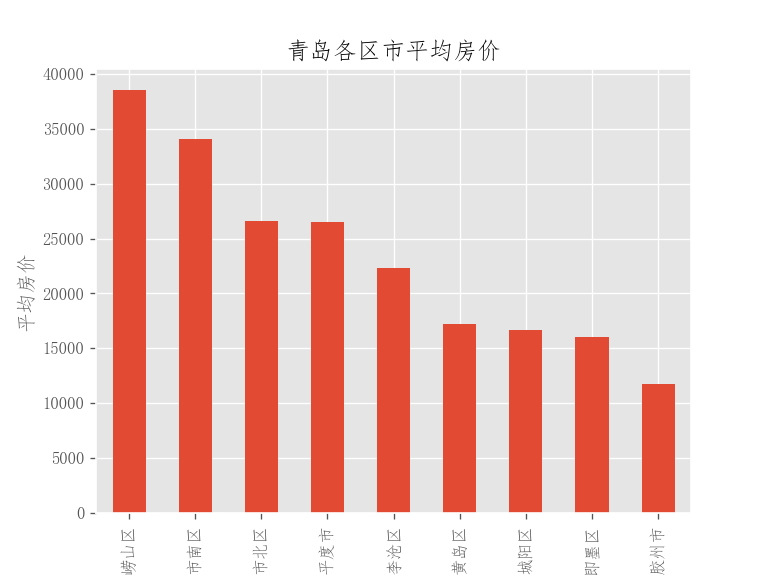

In [12]:
dist_price = pd.DataFrame([housedata['市区'],housedata['元/平米']]).T
dist_price['元/平米'] = pd.to_numeric(dist_price['元/平米'])
mean_price_dist = dist_price.groupby('市区')['元/平米'].mean().sort_values(ascending=False)
mean_price_dist.plot(kind='bar')
#plt.bar(dist_price['市区'],dist_price['元/平米'])
plt.title('青岛各区市平均房价')
plt.ylabel('平均房价')

plt.savefig('fig/districts-price.png')
plt.show()

In [41]:
print(housedata['元/平米'].mean())
print(housedata.loc[housedata['元/平米'].idxmax()])
print(housedata.loc[housedata['元/平米'].idxmin()])

25384.791245791246
标题        一楼复式带200平院子，开发商3000一平精装交付
挂牌价格/万                         1000
元/平米                          90131
tags                          房本满两年
小区名                         山水名园三期 
几室几厅                           4室2厅
总面积                             110
装修情况                             精装
有无电梯                            有电梯
别墅                              NaN
朝向                              南,北
区域                              石老人
楼层高低                            低楼层
楼共有几层                            15
建造年份                           2010
建筑形式                             板楼
几人关注                              1
带看次数                              0
多久以前发布                          3个月
几月以前发布                            3
几年以前发布                            0
几天以前发布                            0
市区                              崂山区
Name: 1527, dtype: object
标题        隆和水岸  交通便利配套齐全，小区环境好
挂牌价格/万                      40
元/平米                      7098
tags                 近地铁,房本满五年
小区名

In [3]:
dist_hot= pd.DataFrame([housedata['市区'],housedata['# people watching'],housedata['# tours']]).T
dist_hot.head()

,市区,# people watching,# tours
0,即墨区,18,6
1,黄岛区,21,23
2,黄岛区,16,11
3,李沧区,26,14
4,黄岛区,26,11


In [4]:
dist_hot_new = pd.DataFrame(dist_hot.groupby(['市区']).sum())
dist_hot_new.rename(columns ={0:'count'})
dist_hot_new.sort_values(['# people watching'], ascending = False,axis = 0,inplace = True )

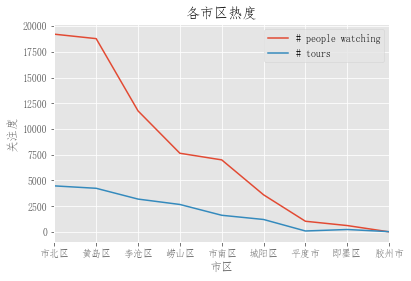

In [5]:
dist_hot_new.plot(kind='line')
plt.title('各市区热度')
plt.ylabel('关注度')
plt.xlabel('市区')
plt.savefig('fig/hotness-over-districts.png')
plt.show()

In [6]:
import folium
from folium.plugins import HeatMap
import numpy as np

In [25]:
newhouse = housedata.copy()
newhouse.sort_values(['元/平米'], ascending = False,axis = 0,inplace = True )

lat = np.array(newhouse["lat"][0:250])                        
lon = np.array(newhouse["lng"][0:250])                        
price = np.array(newhouse["元/平米"][0:250],dtype=float)    
data1 = [[lat[i],lon[i],price[i]] for i in range(0,250)]    # data=[lats,lons,weights]的形式
map_osm = folium.Map(location=[36.06605, 120.36939], zoom_start=12)     
HeatMap(data1).add_to(map_osm) 
file_path = r'fig/price-heatmap.html'
map_osm.save(file_path)     # 保存为html文件

## Feature Engineering
1. take some useful colomns to do feature engineering, 
2. one-hot encoding 
3. and see what are the most correlated variables - correlation analysis
4. take those variables from 3 and try to predict the price 
multivariables prediction problem

In [21]:
new_data = housedata.copy().drop(columns=['标题','小区名','lat','lng'])
new_data.head()

,挂牌价格/万,元/平米,tags,几室几厅,总面积,装修情况,有无电梯,别墅,朝向,区域,楼层高低,楼共有几层,建造年份,建筑形式,市区,# people watching,# tours,public days
0,92.0,12264,房本满两年,1室1厅,75,精装,有电梯,NaN,南,即墨,高楼层,24,2014,板楼,即墨区,18,6,90
1,127.0,14672,房本满两年,2室1厅,86,精装,无电梯,NaN,"南,北",香江路,低楼层,7,2003,板楼,黄岛区,21,23,30
2,130.0,15145,房本满五年,2室1厅,85,精装,NaN,NaN,"南,北",薛家岛,中楼层,24,2011,板楼,黄岛区,16,11,30
3,190.0,22801,"近地铁,房本满两年",2室1厅,83,简装,有电梯,NaN,"南,北",李沧万达,高楼层,31,2013,板楼,李沧区,26,14,5
4,130.0,14445,房本满五年,2室1厅,90,精装,有电梯,NaN,"南,北",薛家岛,低楼层,22,2011,板楼,黄岛区,26,11,8


In [109]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from gensim import corpora,models

def vec_decode(col_name,new_col):
    
    word_list= new_data[col_name]
    word_list = word_list.str.split()
    dictionary = corpora.Dictionary(word_list)
    new_corpus = [dictionary.doc2bow(text) for text in word_list]
    tfidf = models.TfidfModel(new_corpus)
    tfidf_vec = []
    for i in range(len(new_data[col_name])):
        string = new_data[col_name][i]
        string_bow = dictionary.doc2bow(string.split())
        string_tfidf = tfidf[string_bow]
        tfidf_vec.append(string_tfidf)
    #print(tfidf_vec)
    new_data[new_col] =  tfidf_vec
    le = preprocessing.LabelEncoder()
    new_data[new_col] = le.fit_transform(new_data[new_col])
vec_decode('装修情况','Decoration')
vec_decode('几室几厅','room-type')
vec_decode('有无电梯', 'elevator')
vec_decode('别墅', 'if_villa')
vec_decode('建筑形式', 'building_type')
vec_decode('市区', 'districts')
vec_decode('朝向', 'orientation')
vec_decode('tags', 'tags')
vec_decode('楼层高低', 'height')


In [ ]:
new_data['有无电梯']= new_data['有无电梯'].fillna('')
new_data['别墅']= new_data['别墅'].fillna('')
new_data['建筑形式']= new_data['建筑形式'].fillna('')
new_data['tags']= new_data['tags'].fillna('')
new_data['楼层高低']= new_data['楼层高低'].fillna('')

In [ ]:
new_data=new_data.drop(columns = ['几室几厅','装修情况','有无电梯','别墅','朝向','区域','建筑形式','楼层高低','市区'])

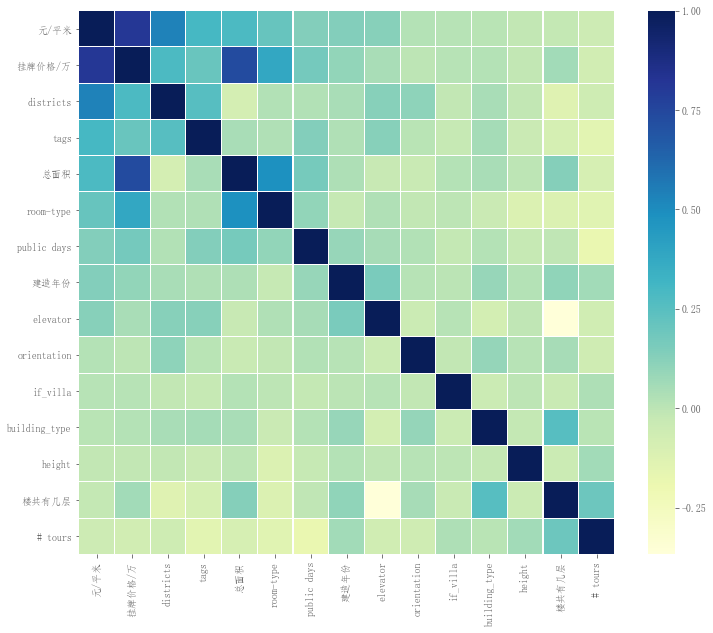

In [134]:

corrmat = new_data.corr() 
cols = corrmat.nlargest(15, '元/平米')['元/平米'].index 
  
cm = np.corrcoef(new_data[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 
plt.savefig("fig/corellation2.png")

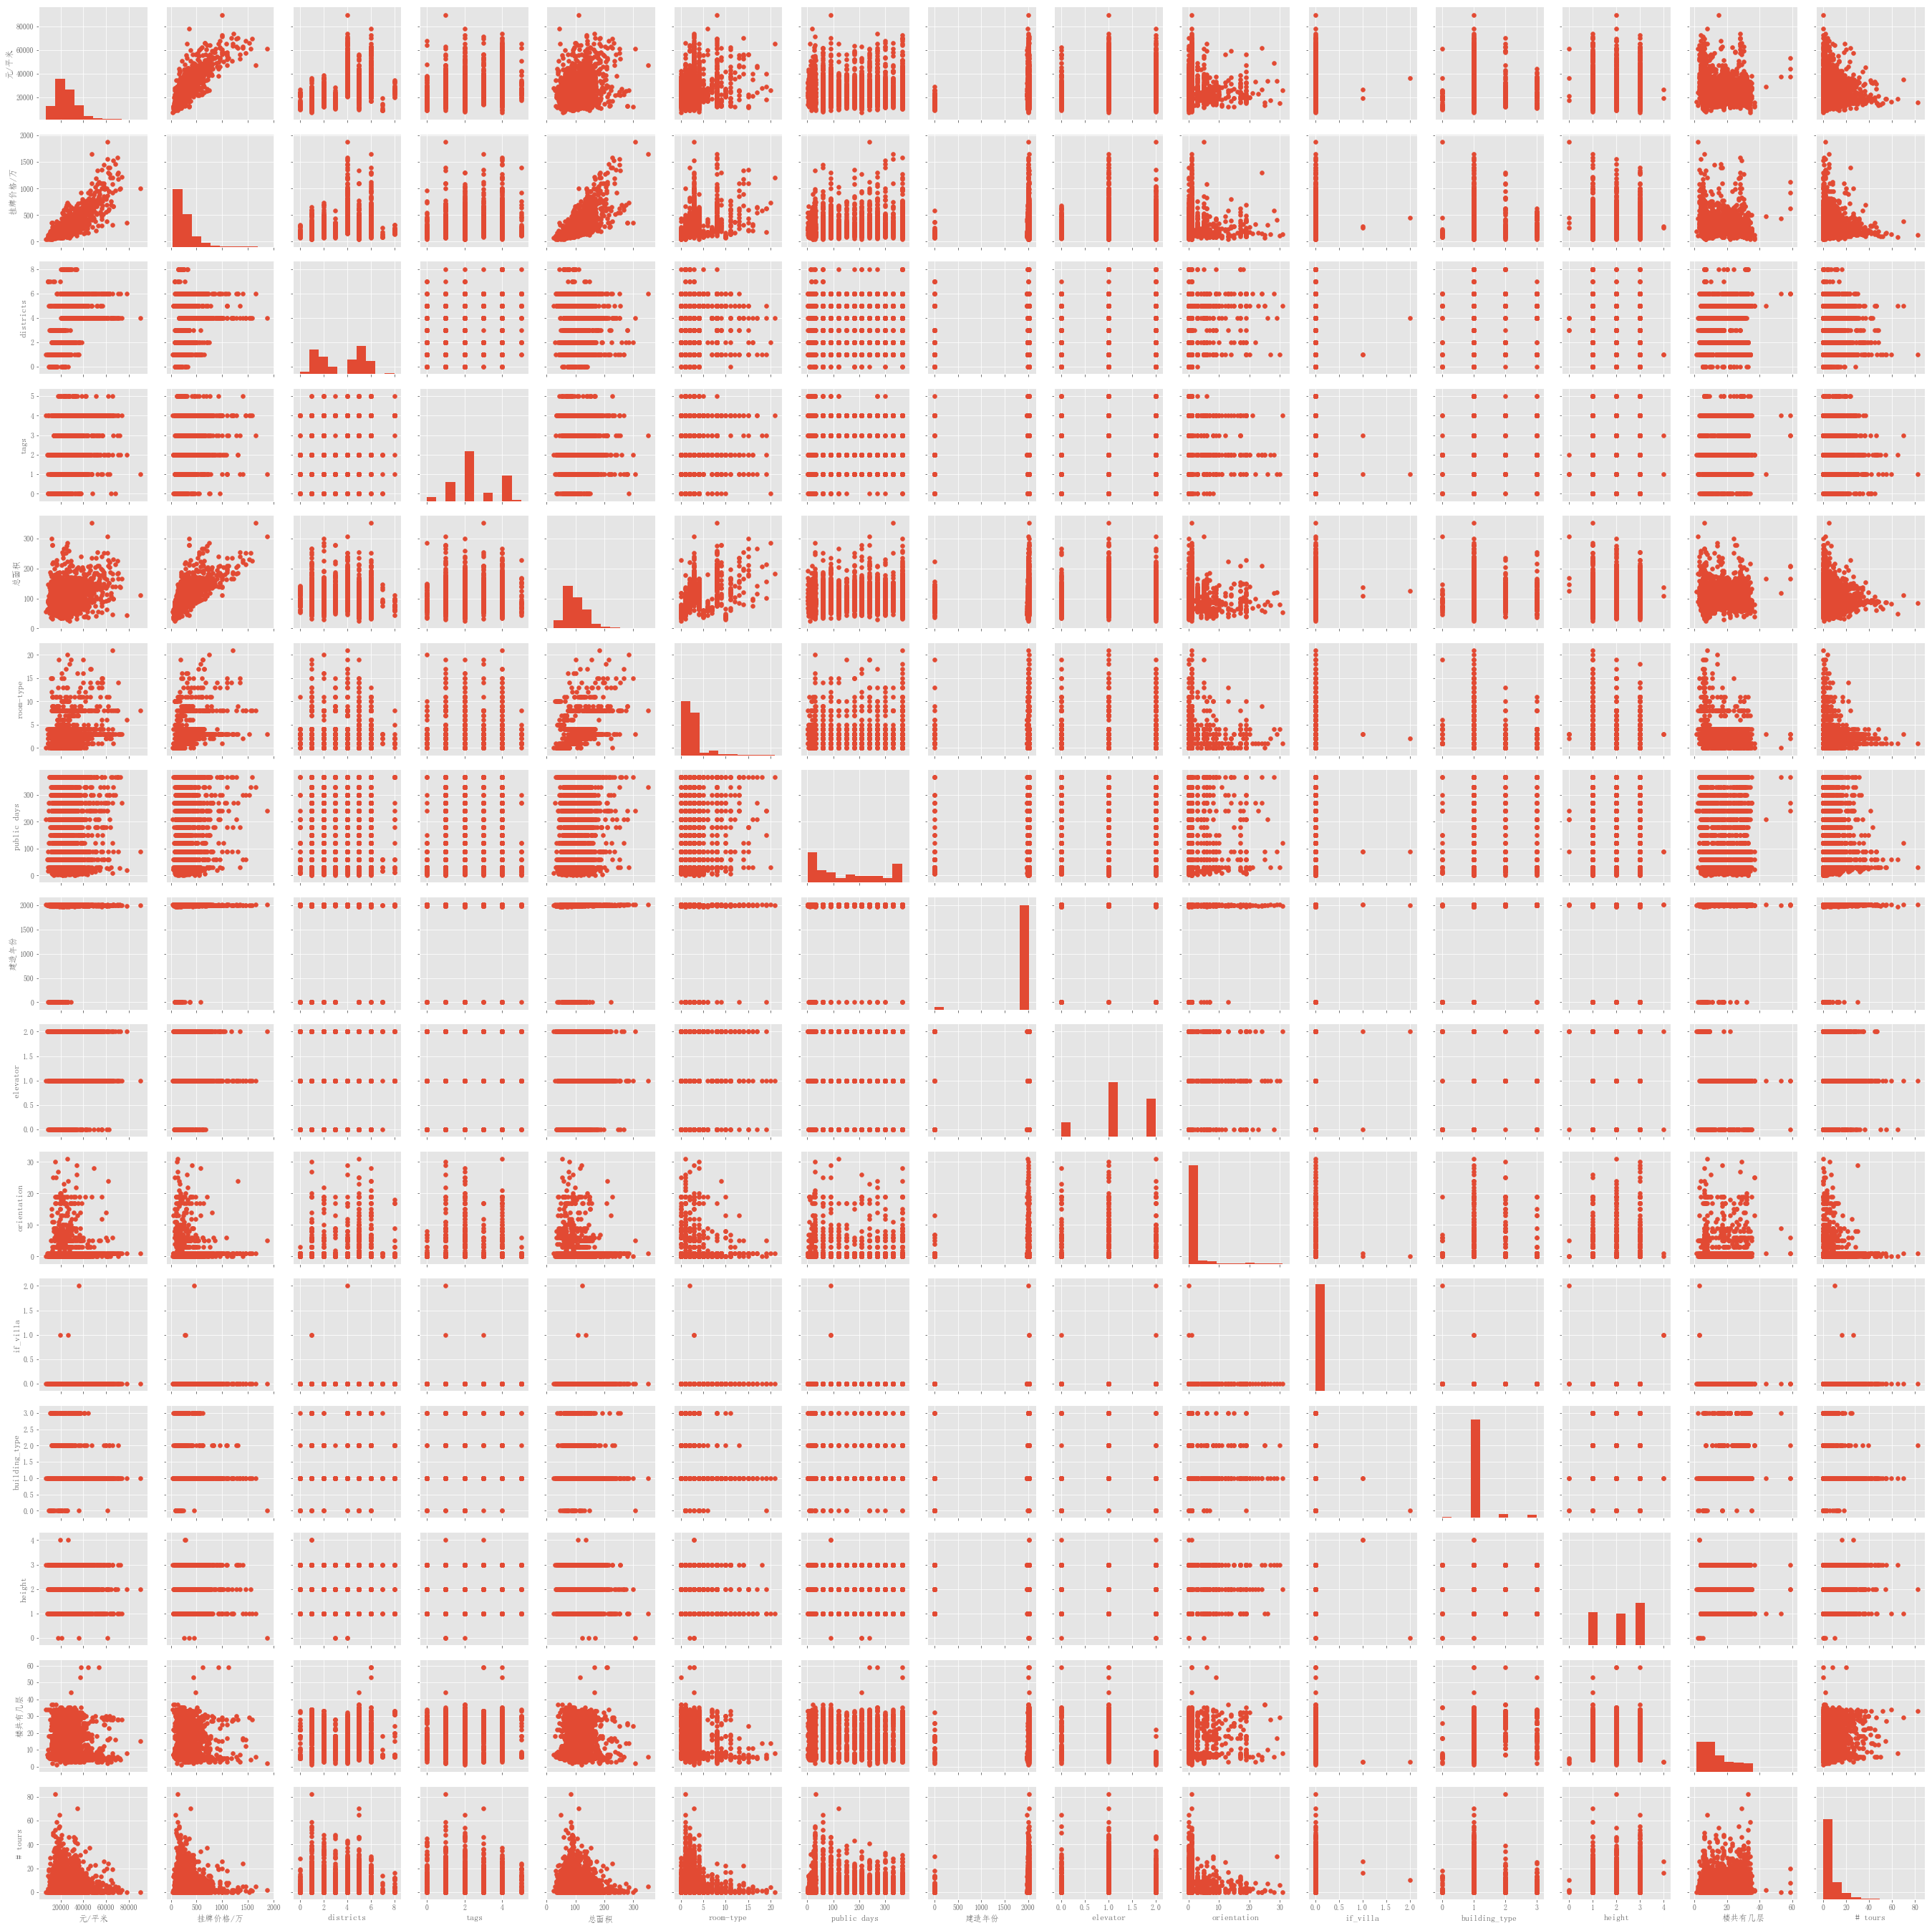

In [131]:
g = sns.PairGrid(new_data[cols])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);
plt.savefig('fig/correlation1.png')
plt.show()

In [138]:
new_data.to_csv('data/lianjia100_clean_FE.csv',index = False,encoding = 'utf-8')

In [139]:
new_data = pd.read_csv('data/lianjia100_clean_FE.csv')
new_data.head()

,挂牌价格/万,元/平米,tags,总面积,楼共有几层,建造年份,# people watching,# tours,public days,Decoration,room-type,elevator,if_villa,building_type,districts,orientation,height
0,92.0,12264,1,75,24,2014,18,6,90,0,0,1,0,1,0,0,1
1,127.0,14672,1,86,7,2003,21,23,30,0,1,2,0,1,1,1,2
2,130.0,15145,2,85,24,2011,16,11,30,0,1,0,0,1,1,1,3
3,190.0,22801,3,83,31,2013,26,14,5,1,1,1,0,1,2,1,1
4,130.0,14445,2,90,22,2011,26,11,8,0,1,1,0,1,1,1,2


0       1
1       1
2       2
3       3
4       2
5       1
6       1
7       0
8       2
9       2
10      0
11      1
12      0
13      0
14      1
15      3
16      4
17      5
18      1
19      5
20      3
21      1
22      2
23      1
24      1
25      0
26      2
27      3
28      5
29      2
       ..
2940    2
2941    4
2942    2
2943    2
2944    4
2945    2
2946    2
2947    2
2948    2
2949    2
2950    4
2951    2
2952    2
2953    2
2954    4
2955    4
2956    2
2957    4
2958    2
2959    2
2960    2
2961    2
2962    2
2963    4
2964    2
2965    2
2966    2
2967    4
2968    2
2969    2
Name: tags, Length: 2970, dtype: int64